In [1]:
from intake import open_catalog
import numpy as np
import xarray as xr
from scipy.io import netcdf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cmocean
from altimetry_tools import filterSpec
import warnings 
warnings.filterwarnings('ignore')

# pull AVISO ugos, vgos from pangeo
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()

In [2]:
# ds['time'][6168]

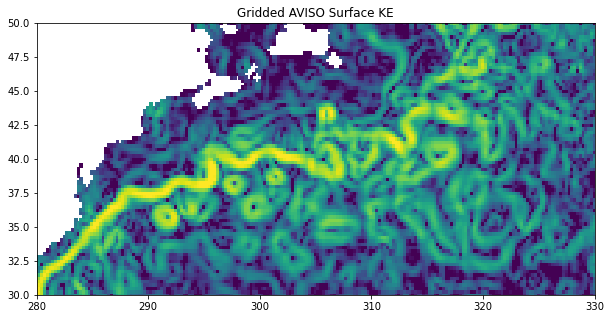

In [2]:
f, ax = plt.subplots(1,1,figsize=(10,5))
ax.pcolor(ds['longitude'], ds['latitude'], 0.5*(ds['ugos'][1]**2 + ds['vgos'][1]**2), norm=LogNorm(vmin=0.001, vmax=1))
ax.set_title('Gridded AVISO Surface KE')
ax.set_xlim([280, 330])
ax.set_ylim([30, 50])
plt.show()

In [7]:
# function Ian helped construct, will filter to: 
# -- constant factor (0.25->1) 
# -- fixed filter scale (relative to smallest grid step in data)
def Laplacian2D(field,landMask,dx,dy):
    """
    Computes a Cartesian Laplacian of field. Assumes dy=constant, dx varies in y direction
    Inputs:
    field is a 2D array (x, y) whose Laplacian is computed
    landMask: 2D array, same size as field: 0 if cell is not on land, 1 if it is on land.
    dx is a 1D array, size size as 2nd dimension of field
    dy is constant
    Output:
    Laplacian of field.
    """
    Nx = np.size(field,0)
    Ny = np.size(field,1) # I suppose these could be inputs
    notLand = 1 - landMask
    # first compute Laplacian in y direction. "Right" is north and "Left" is south for this block
    fluxRight = np.zeros((Nx,Ny))
    fluxRight[:,0:Ny-1] = notLand[:,1:Ny]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxRight[:,Ny-1] = notLand[:,0]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    fluxLeft = np.zeros((Nx,Ny))
    fluxLeft[:,1:Ny] = notLand[:,0:Ny-1]*(field[:,1:Ny] - field[:,0:Ny-1]) # Set flux to zero if on land
    fluxLeft[:,0] = notLand[:,Ny-1]*(field[:,0]-field[:,Ny-1]) # Periodic unless there's land in the way
    OUT = (1/(dy**2))*(fluxRight - fluxLeft)
    # Now compute Laplacian in x direction and add it back in
    fluxRight = 0*fluxRight # re-set to zero just to be safe
    fluxLeft = 0*fluxLeft # re-set to zero just to be safe
    fluxRight[0:Nx-1,:] = notLand[1:Nx,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxRight[Nx-1,:] = notLand[0,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    fluxLeft[1:Nx,:] = notLand[0:Nx-1,:]*(field[1:Nx,:] - field[0:Nx-1,:]) # Set flux to zero if on land
    fluxLeft[0,:] = notLand[Nx-1,:]*(field[0,:]-field[Nx-1,:]) # Periodic unless there's land in the way
    OUT = OUT + (1/(dx**2))*(fluxRight - fluxLeft)
    return OUT*notLand

In [50]:
def Laplacian2D_FV(field,landMask,dx,dy):
    """
    Computes a Cartesian Laplacian of field, using a finite volume discretization. 
    Assumes dy=constant, dx varies in y direction
    Inputs:
    field is a 2D array (y, x) whose Laplacian is computed; note: (y,x) is order of dims in NW2 output 
    landMask: 2D array, same size as field: 0 if cell is not on land, 1 if it is on land.
    dx is a 1D array, same size as 1st dimension of field
    dy is constant
    Output:
    Laplacian of field.
    """
    Ny = np.size(field,0)
    Nx = np.size(field,1)
    notLand = 1 - landMask
    field = np.nan_to_num(field) # set all NaN's to zero
    ## transpose all fields so that numpy broadcasting coorperates (when multiplying with dx)
    field = np.transpose(field)
    notLand = np.transpose(notLand)
    ## Approximate x derivatives on left and right cell boundaries
    fluxLeft = np.zeros((Nx,Ny))
    fluxRight = np.zeros((Nx,Ny))
    fluxRight[0:Nx-1,:] = notLand[1:Nx,:]*(field[1:Nx,:] - field[0:Nx-1,:])/dx # Set flux to zero if on land
    fluxRight[Nx-1,:] = notLand[0,:]*(field[0,:]-field[Nx-1,:])/dx # Periodic unless there's land in the way
    fluxLeft[1:Nx,:] = notLand[0:Nx-1,:]*(field[1:Nx,:] - field[0:Nx-1,:])/dx # Set flux to zero if on land
    fluxLeft[0,:] = notLand[Nx-1,:]*(field[0,:]-field[Nx-1,:])/dx # Periodic unless there's land in the way
    # multiply by length of cell boundary
    fluxLeft = fluxLeft*dy 
    fluxRight = fluxRight*dy
    OUT = fluxRight - fluxLeft
    # Approximate y derivatives on south and north cell boundaries
    fluxNorth = np.zeros((Nx,Ny))
    fluxSouth = np.zeros((Nx,Ny))
    fluxNorth[:,0:Ny-1] = notLand[:,1:Ny]*(field[:,1:Ny] - field[:,0:Ny-1])/dy # Set flux to zero if on land
    fluxNorth[:,Ny-1] = notLand[:,0]*(field[:,0]-field[:,Ny-1])/dy # Periodic unless there's land in the way
    fluxSouth[:,1:Ny] = notLand[:,0:Ny-1]*(field[:,1:Ny] - field[:,0:Ny-1])/dy # Set flux to zero if on land
    fluxSouth[:,0] = notLand[:,Ny-1]*(field[:,0]-field[:,Ny-1])/dy # Periodic unless there's land in the way
    # multiply by length of cell boundary
    # note: the following 4 lines is where this code makes a difference from above Laplacian2D_FD
    fluxNorth[:,0:Ny-1] = fluxNorth[:,0:Ny-1]*(dx[0:Ny-1]+dx[1:Ny])/2 
    fluxNorth[:,Ny-1] = fluxNorth[:,Ny-1]*(dx[Ny-1]+dx[0])/2 # Periodic unless there's land in the way
    fluxSouth[:,1:Ny] = fluxSouth[:,1:Ny]*(dx[0:Ny-1]+dx[1:Ny])/2 
    # fluxSouth[:,0] = fluxSouth[:,0]*(dx[0]+dx[Nx-1])/2 # Periodic unless there's land in the way
    
    # MY EDIT  
    # print(np.shape(fluxSouth))
    # print(Nx)
    # print(np.shape(dx))
    
    fluxSouth[:,0] = fluxSouth[:,0]*(dx[0]+dx[Ny-1])/2 # Periodic unless there's land in the way (CHANGED dx has dimensions Ny NOT Nx)
    OUT = OUT + (fluxNorth - fluxSouth) 
    
    # divide by cell area
    area = dx*dy
    OUT = notLand * OUT/area
    OUT = np.transpose(OUT) # transpose back
    return OUT

In [51]:
# input field with dimensions [time, lat, lon]
def Filter2d(NL,sL,NB,sB,field,dx,dy):  
    # define land mask based on nan bounds of model domain
    Nx = len(field[1, :])
    Ny = len(field[:, 1])
    landMask = 0*np.random.randint(0,2,(Nx,Ny))
    landMask[np.isnan(np.transpose(field))] = 1
    landMask[np.transpose(field == 0)] = 1
    landMask = np.transpose(landMask)
    wetMask = 1 - landMask
    
    data_out = np.nan * np.ones(np.shape(field))        
    data = field.copy()
    data = np.nan_to_num(data) 
    data = data * wetMask # Initalize the filtering process
    print(np.shape(data))
    print(np.shape(landMask))
    for i in range(NL):
        tempL = Laplacian2D_FV(data, landMask, dx, np.int(dy))        # Laplacian1D(data,landMask,dx)
        data = data + (1/sL[i])*tempL # Update filtered field
    for i in range(NB):
        tempL = Laplacian2D_FV(data, landMask, dx, np.int(dy))        # Laplacian1D(data, landMask, dx)
        tempB = Laplacian2D_FV(tempL, landMask, dx, np.int(dy))       # Laplacian1D(tempL, landMask, dx)
        data = data + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB
    data_out = data.copy()  
    
    return(data_out)

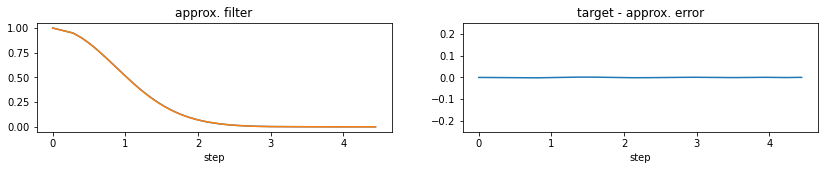

Gaussian, # Laplacian steps: 4; # Biharmonic steps: 2


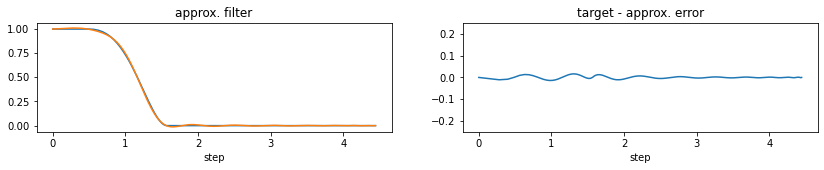

Taper, # Laplacian steps: 18; # Biharmonic steps: 1


In [55]:
filter_fac = 4
Lf_g = filter_fac/np.sqrt(6)
N_g=8
NL_g, sL_g, NB_g, sB_g = filterSpec(N_g, 1, Lf_g, 1, 'Gaussian', X=np.pi)
print('Gaussian, # Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))
Lf_t = filter_fac/2
N_t=20
NL_t, sL_t, NB_t, sB_t = filterSpec(N_t, 1, Lf_t, 1, 'Taper', X=np.pi)
print('Taper, # Laplacian steps: ' + str(NL_t) + '; # Biharmonic steps: ' + str(NB_t))

In [81]:
select_index = 8040  # Jan 6 2015
select_index = 6168  # Nov 21 2009 
test = ds['ugos'][select_index].data
test = test[None, :, :]
Nx = len(test[0, 1, :])
Ny = len(test[0, :, 1])
landMask = 0*np.random.randint(0,2,(Nx,Ny))
landMask[np.isnan(np.transpose(test[0, :, :]))] = 1
landMask[np.transpose(test[0, :, :] == 0)] = 1
landMask = np.transpose(landMask)

In [62]:
# dimensions 
# 1440 = lon
# 720 = lat
# -- my laplacian
# need 1440 x 720 (dx is a 1D array, same size as 2nd dimension of field)
# -- nora's 
# data should be (y,x)
# need (720 x 1440) (dx same size as 1st dimension of field)

In [97]:
# cell area
dy0 = 1852*60*(ds['latitude'][2].data - ds['latitude'][1].data)
dx0 = 1852*60*np.cos(np.deg2rad(ds['latitude'].data))*(ds['longitude'][2].data - ds['longitude'][1].data)
area = dy0*np.tile(dx0[:, None], (1, len(ds['longitude'])))

(720, 1440)

In [106]:
# FILTER
# dy = 1852*60*(ds['latitude'][2].data - ds['latitude'][1].data)
# dx = 1852*60*np.cos(np.deg2rad(ds['latitude'].data))*(ds['longitude'][2].data - ds['longitude'][1].data)
dx = np.ones(len(ds['latitude']))
dy = 1
# filter AVISO 5 day average
u_filtG = Filter2d(NL_g, sL_g, NB_g, sB_g, area*np.nanmean(ds['ugos'][select_index:select_index+6].data, axis=0), dx, dy)
v_filtG = Filter2d(NL_g, sL_g, NB_g, sB_g, area*np.nanmean(ds['vgos'][select_index:select_index+6].data, axis=0), dx, dy)
u_filtS = Filter2d(NL_t, sL_t, NB_t, sB_t, area*np.nanmean(ds['ugos'][select_index:select_index+6].data, axis=0), dx, dy)
v_filtS = Filter2d(NL_t, sL_t, NB_t, sB_t, area*np.nanmean(ds['vgos'][select_index:select_index+6].data, axis=0), dx, dy)
u_filtG = u_filtG/area
v_filtG = v_filtG/area
u_filtS = u_filtS/area
v_filtS = v_filtS/area

(720, 1440)
(720, 1440)
(720, 1440)
(720, 1440)
(720, 1440)
(720, 1440)
(720, 1440)
(720, 1440)


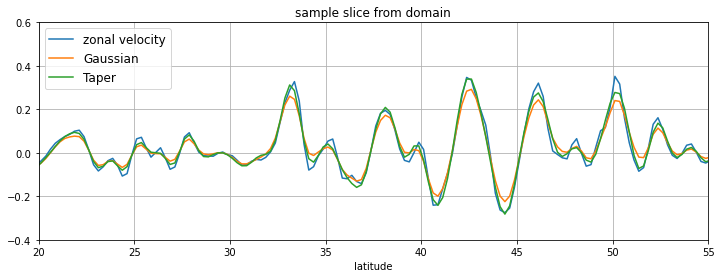

In [104]:
f, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ds['latitude'].data, ds['ugos'][select_index][:, 1300], label='zonal velocity')
ax.plot(ds['latitude'].data, u_filtG[:, 1300], label='Gaussian')
ax.plot(ds['latitude'].data, u_filtS[:, 1300], label='Taper')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12, loc='upper left')
ax.set_title('sample slice from domain')
ax.set_xlabel('latitude')
ax.set_xlim([20,55])
ax.set_ylim([-0.4, 0.6])
ax.grid()
plt.show()

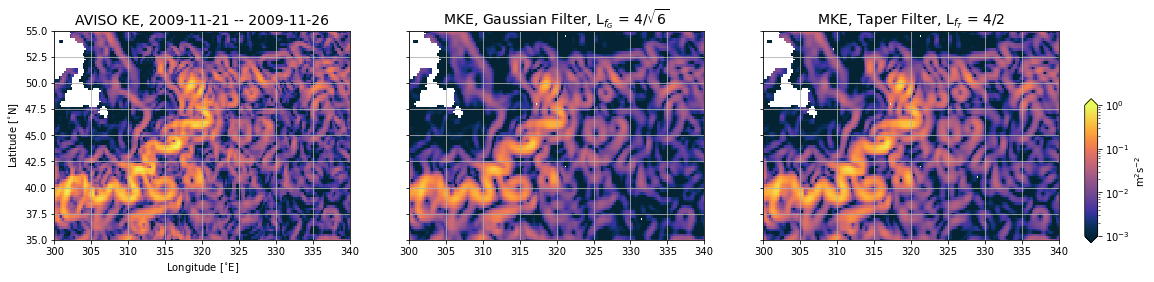

In [108]:
ke = np.nanmean(0.5*(ds['ugos'][select_index:select_index+6]**2 + ds['vgos'][select_index:select_index+6]**2),axis=0)
ke_filtG = np.array([0.5*(u_filtG**2 + v_filtG**2)])[0]
ke_filtG[landMask > 0] = np.nan
ke_filtS = np.array([0.5*(u_filtS**2 + v_filtS**2)])[0]
ke_filtS[landMask > 0] = np.nan

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,4),sharex=True,sharey=True)
axp = ax1.pcolor(ds['longitude'], ds['latitude'], ke, norm=LogNorm(vmin=0.001, vmax=1), cmap=cmocean.cm.thermal)
ax2.pcolor(ds['longitude'], ds['latitude'], ke_filtG, norm=LogNorm(vmin=0.001, vmax=1), cmap=cmocean.cm.thermal)
ax3.pcolor(ds['longitude'], ds['latitude'], ke_filtS, norm=LogNorm(vmin=0.001, vmax=1), cmap=cmocean.cm.thermal)
this_time = str(ds['time'][select_index].data)
this_time2 = str(ds['time'][select_index+5].data)
ax1.set_title('AVISO KE, ' + this_time[0:10] + ' -- ' + this_time2[0:10], fontsize=14)
ax1.set_xlabel('Longitude [$^{\circ}$E]')
ax1.set_ylabel('Latitude [$^{\circ}$N]')
ax2.set_title(r'MKE, Gaussian Filter, L$_{f_G}$ = 4/$\sqrt{6}$', fontsize=14)
ax3.set_title(r'MKE, Taper Filter, L$_{f_T}$ = 4/2', fontsize=14)
ax1.set_xlim([300, 340])
ax1.set_ylim([35, 55])
cbpos = [0.92, 0.13, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='m$^2$s$^{-2}$')
w = 1 / np.cos(np.deg2rad(45))
ax1.set_aspect(w)
ax2.set_aspect(w)
ax3.set_aspect(w)
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()
f.savefig('aviso_filtered_velocity.jpg', dpi=400)

In [109]:
file_out = 'aviso_ke.nc'
save_nc = 1
if save_nc > 0:
    OL_out = netcdf.netcdf_file(file_out, 'w')
    OL_out.title = 'aviso surface geostrophic velocity'
    # OL_out.subtitle = 'center lat,lon = ' + str(lat_0) + ',' + str(lon_0)
    # create dimenision
    x_dim = OL_out.createDimension('lon_dim', len(ds['longitude']))
    y_dim = OL_out.createDimension('lat_dim', len(ds['latitude']))
    # assign variables
    x_out = OL_out.createVariable('longitude', np.float64, ('lon_dim',)) # np.float64,
    x_out[:] = ds['longitude']
    y_out = OL_out.createVariable('latitude', np.float64, ('lat_dim',))
    y_out[:] = ds['latitude'] 
    area_out = OL_out.createVariable('area', np.float64, ('lat_dim', 'lon_dim'))
    area_out[:] = area
    u_out = OL_out.createVariable('ugos', np.float64, ('lat_dim', 'lon_dim'))
    u_out[:] = np.nanmean(ds['ugos'][select_index:select_index+6].data, axis=0)
    v_out = OL_out.createVariable('vgos', np.float64, ('lat_dim', 'lon_dim'))
    v_out[:] = np.nanmean(ds['vgos'][select_index:select_index+6].data, axis=0)
    ke_out = OL_out.createVariable('ke', np.float64, ('lat_dim', 'lon_dim'))
    ke_out[:] = ke
    ke_g_out = OL_out.createVariable('ke_gaussian', np.float64, ('lat_dim', 'lon_dim'))
    ke_g_out[:] = ke_filtG
    ke_s_out = OL_out.createVariable('ke_taper', np.float64, ('lat_dim', 'lon_dim'))
    ke_s_out[:] = ke_filtS  
    OL_out.close() 